<a href="https://colab.research.google.com/github/giveyourselfaTRY/M2A-RLD-TP-PROJET/blob/main/TP14_Neural_ODE_student_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# TP 14: Predicting dynamics with Neural-ODE

**The goal of this pratical is use machine learning models to predict the
evolution of dynamical systems driven by physical laws, *e.g.* ordinary
Differential Equations (ODE).**

Let us considers a physcial system in Newtonian mechanichs composed of a
**damped pendulum**, with length $l$ and mass $m$, and $\theta$ being the
angle with respect to the vertical direction:

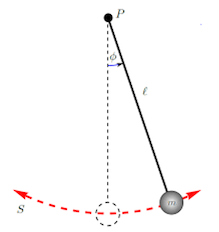

**Let us denote $\dot{\theta_t}:=\frac{d\theta}{dt}$ and
$\ddot{\theta}_t:=\frac{d^2\theta}{dt^2}$ as the first and second temporal
derivatives of $\theta$.** The dynamics of the pendulum is driven by the
following ODE on $\theta$:

\begin{equation} \ddot{\theta_t} + \omega_0^2~ sin\left(\theta_t\right) +
\alpha \dot{\theta}_t = 0 \end{equation}

where $\omega_0 = \sqrt{\frac{g}{\ell}}$ ($g$ is the gravitational constant, i.e. $9.8 ms^{-2}$), $\ell$ is the length of the rod,
and $\alpha = \frac{k}{ml^2}$ is the friction coefficient.

In the general case, the ODE does not have a closed-form
solution. Let us denote as $\mathbf{Y}_t=(\theta_t, \dot{\theta}_t)$ the 2d
state vector of the pendulum.



**<u>Question 1:</u> show that
 $\dot{\mathbf{Y}_t}=f\left({\mathbf{Y}_t}\right)$, *i.e* that the evolution
 of $\mathbf{Y}$ follows a first-order ODE. Give the expression of f.**


From a given initial condition $\mathbf{Y}_0=(\theta_0, \dot{\theta}_0)$, we
can estimate the state vector $\mathbf{Y}_t$ at any time $t$:

\begin{equation} \mathbf{Y}_t = \mathbf{Y}_0 + \int_0^t \dot{\mathbf{Y}_t} ~dt
= \mathbf{Y}_0 + \int_0^t f\left(\mathbf{Y}_t\right) dt
\end{equation}

where $f\left( \mathbf{Y}_t \right)$ only depends on the current state
$\mathbf{Y}_t$ at time $t$. The integral can be approximated
with numerical schemes. The Euler method is simplest one (see figure below):
starting from $\mathbf{Y}_0$, we have $\mathbf{Y}_{t+1} = \mathbf{Y}_{t} +
f\left(\mathbf{Y}_t\right)$ $\forall t>1$. The has been extensive studies for
developing improved numerical solvers in the last centuries, e.g. different
orders of Runge-Kutta solvers.

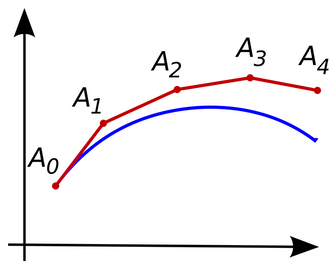


## Part I. Generating damped pendulum simulations
First, lets do some import

In [1]:
import math, shelve
import os

from collections import OrderedDict

import torch
import numpy as np
from scipy.integrate import solve_ivp

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim

!pip install torchdiffeq
from torchdiffeq import odeint_adjoint, odeint

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [20, 10]

### I.a) DampledPendulum

**We will write a DampledPendulum Dataset, which simulates different pendulum trajectories from differents initial conditions. Fill the code in the code in the following DampledPendulum class. We use the following setting:** $\omega_0= \frac{\Pi}{3}$, $\alpha= 0.2$, time hoziron : 10, with $dt=0.5$

You have to fill the `__init__` and `_compute_trajectory` functions. For `_compute_trajectory`, the goal is to simulate a given trajectory from an initial condition:
- The function `_get_initial_condition` is provided
- To perform the simulation in `_compute_trajectory`, you need to:
    - Call the `_get_initial_condition`
    - Call the solver: we will use the solve_ivp method from from `scipy.integrate`, using the 'DOP853' method (Explicit Runge-Kutta method of order 8).
- Since the simulation is computationally demanding, the class below uses a cache to store each trajectory

`_get_initial_condition`: $y_0$ $= \frac{r}{\|y_0'\|} y_0'$
* $y_0'$​ 是原始生成的向量 [$ θ',\dot{\theta}']$，它的元素来自扩展和偏移调整的正态分布。
* $∥y_0'​∥$ 是 $y_0'$ 的欧几里得范数。
* $r$ 是一个随机生成的正实数，用于调整向量的长度。


**数学模型**

阻尼摆系统的运动方程由以下二阶微分方程给出：
$\ddot{\theta} + \alpha \dot{\theta} + \omega_0^2 \sin(\theta) = 0
$

其中：

  * $\theta$ 表示摆动的角度（从垂直向下位置开始计算）。
  * $\dot{\theta}$ 是角速度，即角度随时间的变化率。
  * $\ddot{\theta}$ 是角加速度，即角速度随时间的变化率。
  * $\alpha$ 是阻尼系数，代表系统的阻尼作用，这会减缓摆动。
  * $\omega_0$ 是系统的自然频率，这里的 $\omega_0^2 = \left(\frac{\pi}{3}\right)^2$。


**转换为一阶**

为了使用常微分方程的数值解法，我们通常将二阶微分方程转化为一阶微分方程的系统。我们定义状态向量 $x = \begin{bmatrix} \theta \\ \dot{\theta} \end{bmatrix}$，则对应的一阶系统如下：
$
\frac{d}{dt} \begin{bmatrix} \theta \\ \dot{\theta} \end{bmatrix} = \begin{bmatrix} \dot{\theta} \\ -\omega_0^2 \sin(\theta) - \alpha \dot{\theta} \end{bmatrix}$

In [2]:
class DampledPendulum(Dataset):
    def __init__(self, num_seq: int, time_horizon: int, dt: float):
        """Creates a new dataset of trajectories

        :param num_seq: Size of the dataset
        :param time_horizon: _description_
        :param dt: _description_
        """
        super().__init__()

        # À compléter...

        self.omega0_square= (math.pi/3)**2 # FILL WITH YOUR CODE
        self.alpha = 0.2 # FILL WITH YOUR CODE
        self.len = num_seq # NUMBER OF SEQUENCES IN DATASET - FILL WITH YOUR CODE
        self.time_horizon = 10 # FILL WITH YOUR CODE

        # This caches the trajectories so we compute them once only
        self.data = [None] * num_seq

        self.t_eval = torch.arange(0, self.time_horizon, float(dt))

    def __getitem__(self, index: int):
        if self.data[index] is None:
            self.data[index] = torch.tensor(self._compute_trajectory(), dtype=torch.float32)
        return {"states": self.data[index], "t": self.t_eval}

    def __len__(self):
        return len(self.data)

    def _get_initial_condition(self):
        """Returns the vector of initial conditions"""
        y0 = np.random.randn(2) * 2.0 - 1
        r = np.random.rand() + 1.3
        y0 = y0 / np.sqrt((y0**2).sum()) * r

        return y0

    def _get__state_derivative(self, t, x):  # coords = [q,p]
        # À compléter...
        theta,omega=x
        dtheta_dt=omega
        domega_dt=-self.omega0_square*np.sin(theta)-self.alpha*omega
        return [dtheta_dt,domega_dt]

    def _compute_trajectory(self):
        # À compléter... #
        y0 = self._get_initial_condition()
        sol=solve_ivp(self._get__state_derivative,t_span=(0,self.time_horizon),y0=y0,method='DOP853',t_eval=self.t_eval.numpy())
        states=sol.y.T
        return states




### I.b) Train/test data generation

**We can now define train and test dataloader** (use 25 train/test sequences
with a batch size of 25). **Plot the resulting trajectories ($\theta$ and
optionally $\dot{\theta}$).**

In [3]:
# path = "./exp2/pendulum/pendulum"

num_seq = 25
time_horizon = 20
dt = 0.5
dataset_train = DampledPendulum(num_seq, time_horizon, dt)
dataset_test = DampledPendulum(num_seq, time_horizon, dt)


batch_size = 25

train_loader = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
    shuffle=True,
)
test_loader = DataLoader(
    dataset=dataset_test,
    batch_size=batch_size,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
    shuffle=False,
)

In [4]:
# Show one item of the dataset

dataset_train[0]

{'states': tensor([[-1.3835, -0.0739],
         [-1.2887,  0.4428],
         [-0.9550,  0.8719],
         [-0.4461,  1.1242],
         [ 0.1218,  1.0972],
         [ 0.6055,  0.8010],
         [ 0.8991,  0.3617],
         [ 0.9641, -0.0975],
         [ 0.8116, -0.4975],
         [ 0.4882, -0.7681],
         [ 0.0773, -0.8394],
         [-0.3147, -0.6927],
         [-0.5901, -0.3929],
         [-0.6977, -0.0358],
         [-0.6301,  0.2951],
         [-0.4198,  0.5307],
         [-0.1240,  0.6207],
         [ 0.1741,  0.5457],
         [ 0.4004,  0.3414],
         [ 0.5045,  0.0751]]),
 't': tensor([0.0000, 0.5000, 1.0000, 1.5000, 2.0000, 2.5000, 3.0000, 3.5000, 4.0000,
         4.5000, 5.0000, 5.5000, 6.0000, 6.5000, 7.0000, 7.5000, 8.0000, 8.5000,
         9.0000, 9.5000])}

In [5]:
dataset_train[0]['states'].shape

torch.Size([20, 2])

In [6]:
dataset_train[0]['t'].shape

torch.Size([20])

<Figure size 2000x1000 with 0 Axes>

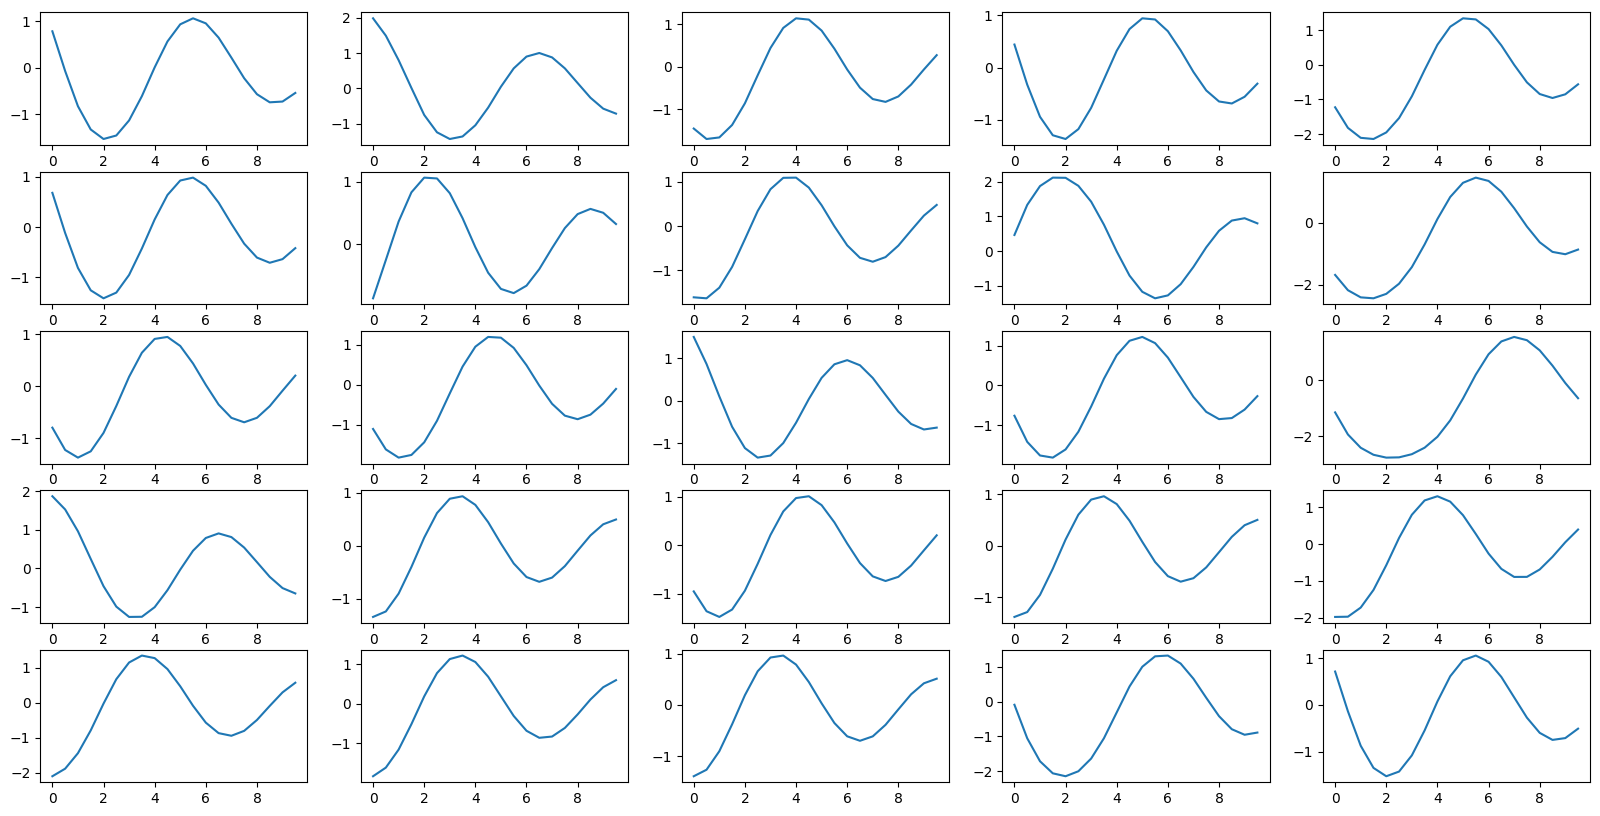

In [7]:
data = next(iter(train_loader))
draw_dottheta = False
# print(data["t"].shape)
# print(data["states"].shape)

plt.figure()
plt.rcParams["figure.figsize"] = [20, 10]
fig, axs = plt.subplots(5, 5)

for i in range(5):
    for j in range(5):
        # fig, (ax1, ax2) = plt.subplots(i+1, j+1)
        # plt.plot(data['t'][i*5+j],data['states'][i*5+j,0,:])
        # print(data["t"][i * 5 + j].shape)
        # print(data["states"][i * 5 + j, :, 0].shape)
        axs[i, j].plot(data["t"][i * 5 + j], data["states"][i * 5 + j, :,0])


if draw_dottheta == True:
    fig, axs = plt.subplots(5, 5)
    for i in range(5):
        for j in range(5):
            axs[i, j].plot(data["t"][i * 5 + j], data["states"][i * 5 + j, :,1])

<Figure size 2000x1000 with 0 Axes>

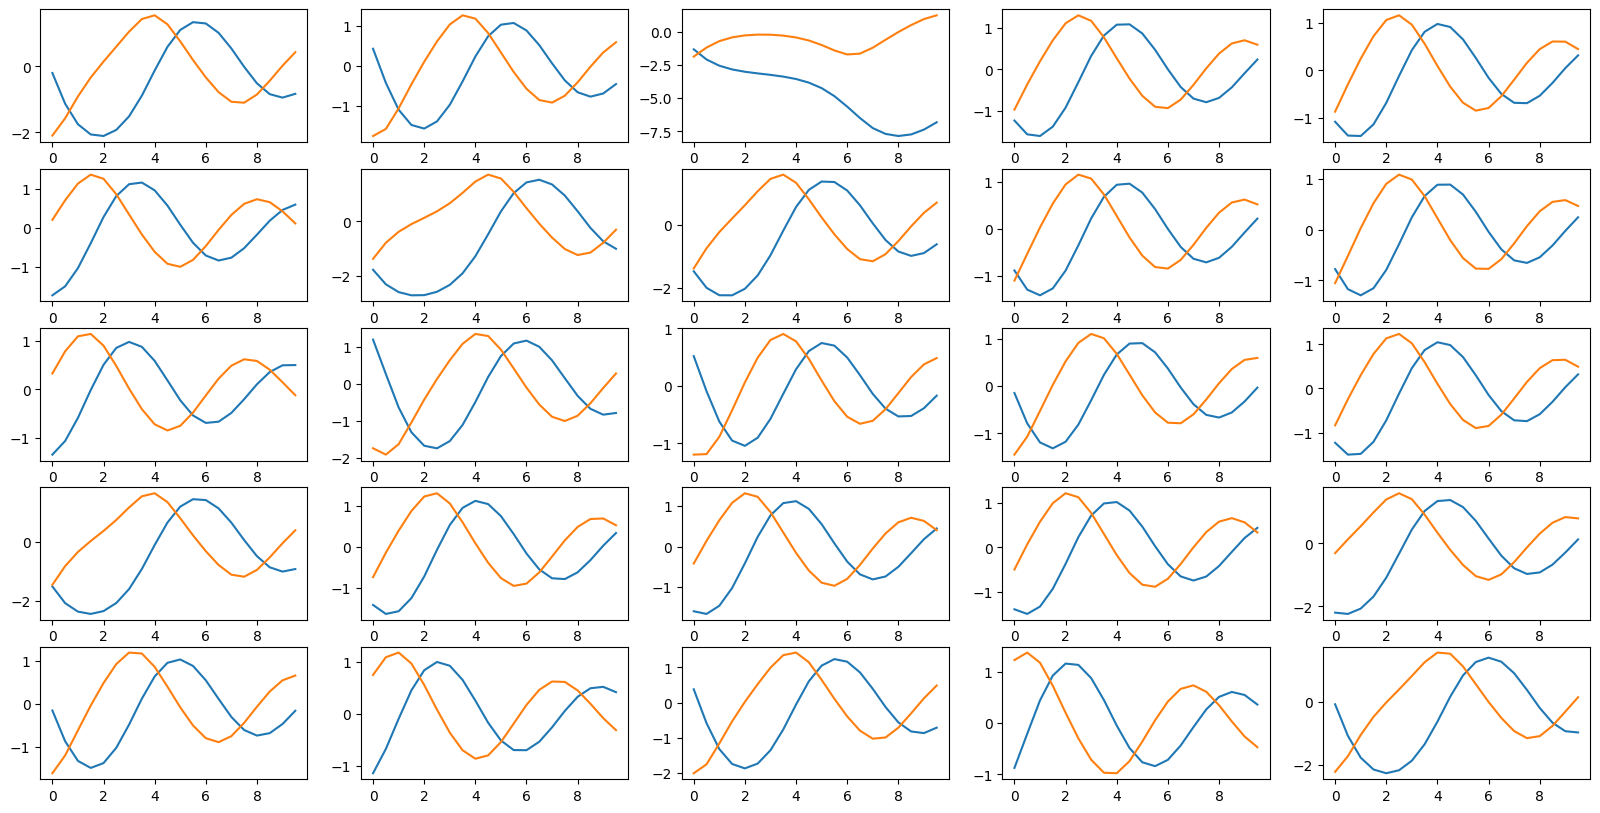

In [8]:
data_test = next(iter(test_loader))

plt.figure()
plt.rcParams["figure.figsize"] = [20, 10]
fig, axs = plt.subplots(5, 5)
draw_dottheta = True

for i in range(5):
    for j in range(5):
        # fig, (ax1, ax2) = plt.subplots(i+1, j+1)
        # plt.plot(data['t'][i*5+j],data['states'][i*5+j,0,:])
        axs[i, j].plot(data_test["t"][i * 5 + j], data_test["states"][i * 5 + j,  :,0])

if draw_dottheta:
    for i in range(5):
        for j in range(5):
            # fig, (ax1, ax2) = plt.subplots(i+1, j+1)
            # plt.plot(data['t'][i*5+j],data['states'][i*5+j,0,:])
            axs[i, j].plot(
                data_test["t"][i * 5 + j], data_test["states"][i * 5 + j, :,1]
            )


### Plot initial condition distribution

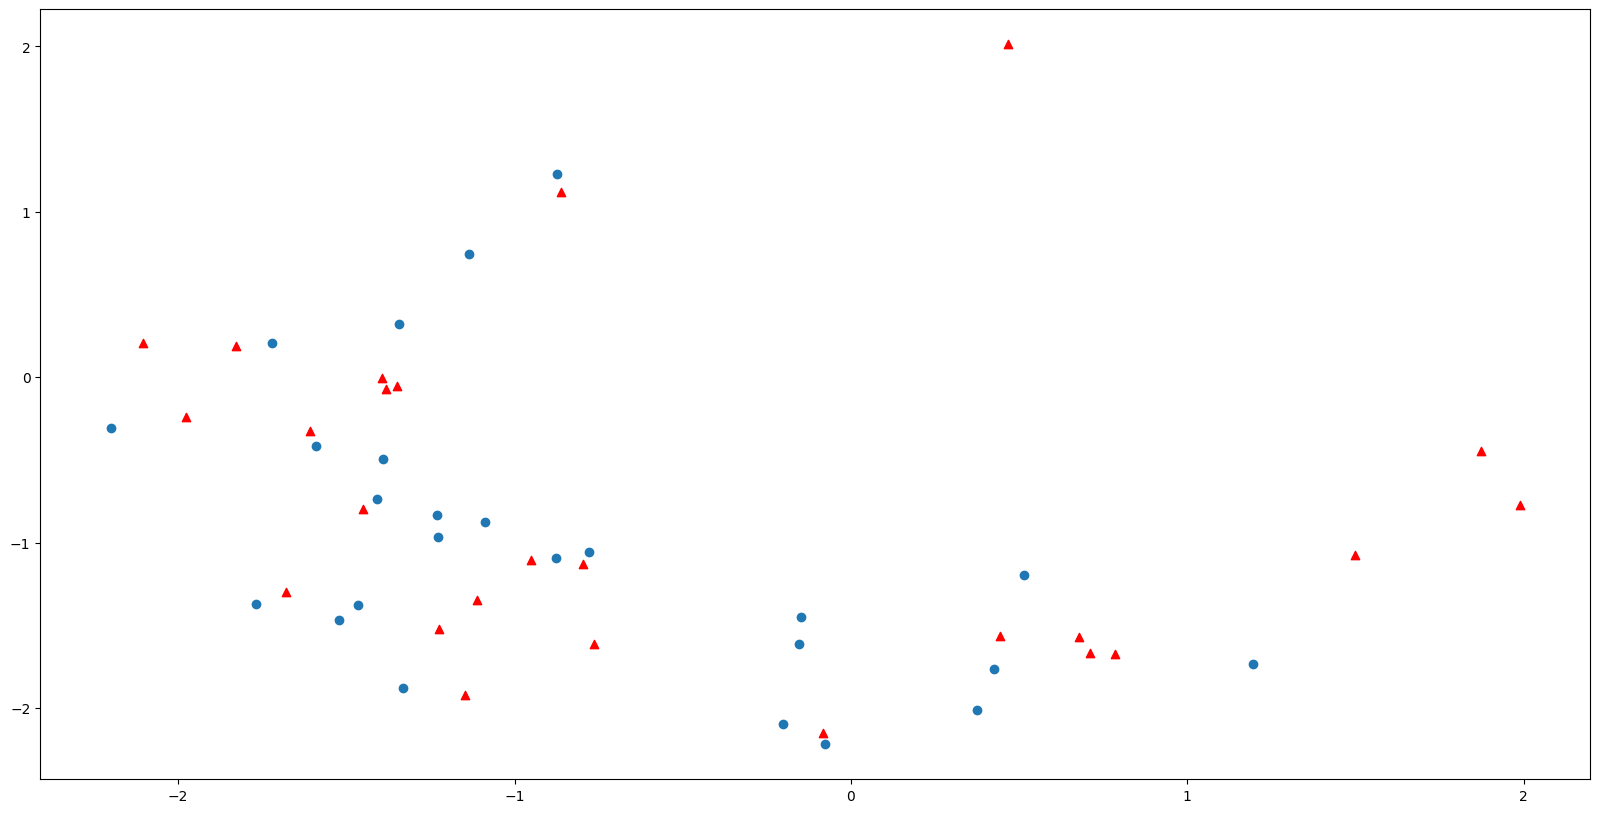

In [9]:
theta0_train = data["states"][:, 0, 0]
dtheta0_train = data["states"][:, 0, 1]

theta0_test = data_test["states"][:, 0, 0]
dtheta0_test = data_test["states"][:, 0, 1]

plt.figure()
plt.scatter(theta0_train, dtheta0_train, marker="^", c="r")
plt.scatter(theta0_test, dtheta0_test)

# print(data["states"].shape)


## 2) Predicting trajectories with Neural-ODE

The goal is to use the Neural-ODE method [1] to predict the future trajectory
from an initial condition. **More precisely, the idea is to define a
parametric model, *e.g.* an neural network, to predict the state's derivative
from the current state value:
$\dot{\mathbf{Y}_t}=f_{\theta}\left({\mathbf{Y}_t}\right)$, with $\theta$
being the neural net parameters. From an initial condition $\mathbf{Y}_0$ and
$f_{\theta}\left({\mathbf{Y}_t}\right)$, we can then use Equation below to
predict the full predicted trajectory $\hat{\mathbf{Y}}$. The goal is to
optimize $\theta$ parameters such that predicted trajectories are close to the
GT trajectories in the training set.**

\begin{equation} \hat{\mathbf{Y}_t}  = \mathbf{Y}_0 + \int_0^t
f_{\theta}\left(\mathbf{Y}_t\right) dt \end{equation}


**Let's fill the DerivativeEstimator class to predict the the state's
derivative.** We will use a simple MLP (2 hidden layers + ReLU) for prediction
since the state is a 2D vector.


In [10]:
class DerivativeEstimator(nn.Module):
    def __init__(self, n_state: int, n_hidden: int):
        super().__init__()
        # À compléter...
        self.fc1 = nn.Linear(n_state, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.output = nn.Linear(n_hidden, n_state)
        self.relu = nn.ReLU()

    def forward(self, t, state):
        # À compléter...
        x=self.relu(self.fc1(state))
        x=self.relu(self.fc2(x))
        x=self.output(x)
        return x


**The forecaster will perform the prediction from a initial state $y_0$**. To
perform the numerical integration, we use the [`odeint` method from
torchdiffeq](https://github.com/rtqichen/torchdiffeq). We will use the generic
'rk4' solver to perform numerical integration. **Fill the following Forecaster
class with:**
- A constructor creating a reference to an DerivativeEstimator instance
- the forward method calls the `odeint` method to perform integration from an
  initial $y_0$ state. **N.B.**: the output dimensions after calling `odeint`
  will be `T x batch_size x n_c`, swap them to fit the requested Pytorch
  standard (`batch_size x n_c X T`)

In [11]:
class Forecaster(nn.Module):
    def __init__(self, n_state, n_hidden, method="rk4"):
        super().__init__()
        self.derivative_estimator = DerivativeEstimator(n_state, n_hidden)
        self.method = method #积分方法



    def forward(self, y0: torch.Tensor, t: torch.LongTensor):
        """Computes the $y_t$ prediction at times $t$
        given the initial state y0 of size (B x N_c).

        Returns a tensor of shape (B x N_c x T)
        """
        # À compléter...
        # 使用 odeint 进行数值积分
        prediction = odeint(self.derivative_estimator, y0, t[0,:], method=self.method)
        prediction=prediction.permute(1,2,0)
        return prediction


### Write the training loop!

For each batch:
- Get the first state of each training trajectory
- Perform prediction of the forecaster for each time step of the horizon
- We will use a simple MSE loss between the ground truth and predicted
  trajectories.
- Use an Adam optimizer (default paramters)
- Plot the train / test trajectories

In [12]:
n_state = 2
n_hidden = 200
n_epochs = 1001
# tau_1 = 1e-3

forecaster_net = Forecaster(n_state, n_hidden)
optimizer = optim.Adam(forecaster_net.parameters())  # , lr=tau_1, betas=(0.9, 0.999))
traj_loss = nn.MSELoss()

for e in range(n_epochs):
    # À compléter...
    for batch in train_loader:
        y0 = batch["states"][:, 0, :]

        t = batch["t"]
        # print(t.shape)
        y_true=batch["states"].permute(0,2,1)
        # print(y_true.shape)

        forecaster_net.train()
        optimizer.zero_grad()
        y_pred=forecaster_net(y0,t)
        # print(y_pred.shape)
        loss=traj_loss(y_pred,y_true)
        loss.backward()
        optimizer.step()
    if e % 100 == 0:
        print(f'Epoch {e}: Loss = {loss.item()}')



Epoch 0: Loss = 2.1288044452667236
Epoch 100: Loss = 0.02679898962378502
Epoch 200: Loss = 0.0027907099574804306
Epoch 300: Loss = 0.0007538354257121682
Epoch 400: Loss = 0.009542708285152912
Epoch 500: Loss = 0.0006543800118379295
Epoch 600: Loss = 0.0003292492765467614
Epoch 700: Loss = 0.0019846570212394
Epoch 800: Loss = 0.0019917073659598827
Epoch 900: Loss = 0.0014635755214840174
Epoch 1000: Loss = 0.00028375096735544503


In [28]:
# Assuming you have a DataLoader for training and testing datasets
# and a Forecaster model defined and trained
# Here's how you could generate predictions:

# Ensure the model is in evaluation mode
forecaster_net.eval()

# Generating predictions for the training dataset
with torch.no_grad():
    pred = []
    for batch in train_loader:
        y0 = batch['states'][:, 0, :]  # Assuming the initial state is at the first time point
        t = batch['t']  # Assuming 't' is properly broadcastable or adjusted as per earlier discussion
        predictions = forecaster_net(y0, t)  # Get predictions from the model
        pred.append(predictions)

    pred = torch.cat(pred, dim=0)  # Concatenate list of tensors into a single tensor

# Generating predictions for the testing dataset
with torch.no_grad():
    pred_test = []
    for batch_test in test_loader:
        y0 = batch_test['states'][:, 0, :]
        t = batch_test['t']
        predictions = forecaster_net(y0, t)
        pred_test.append(predictions)

    pred_test = torch.cat(pred_test, dim=0)  # Concatenate list of tensors into a single tensor


<Figure size 2000x1000 with 0 Axes>

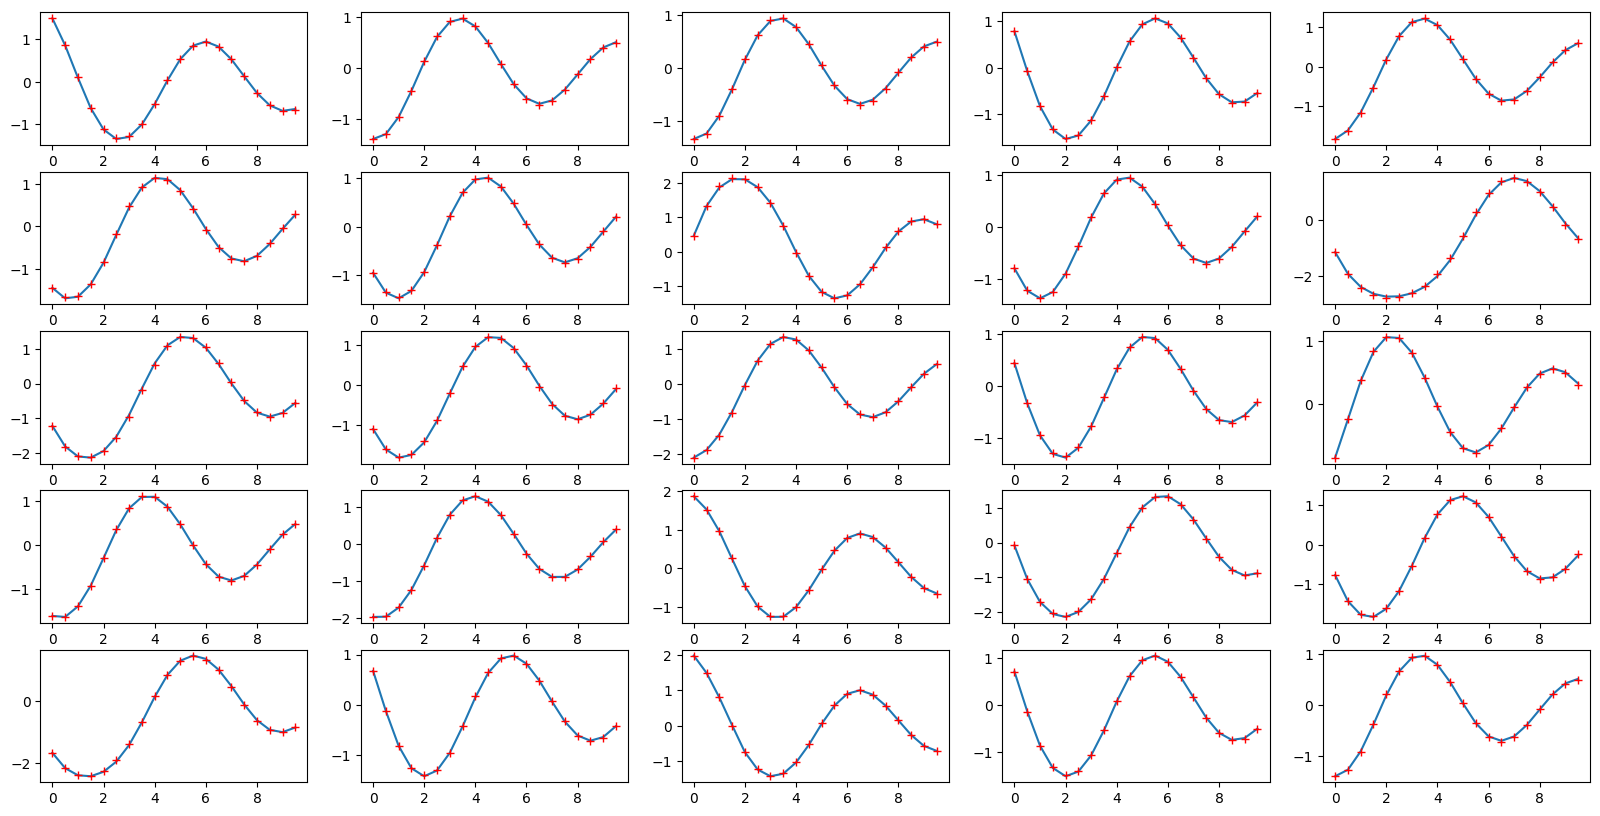

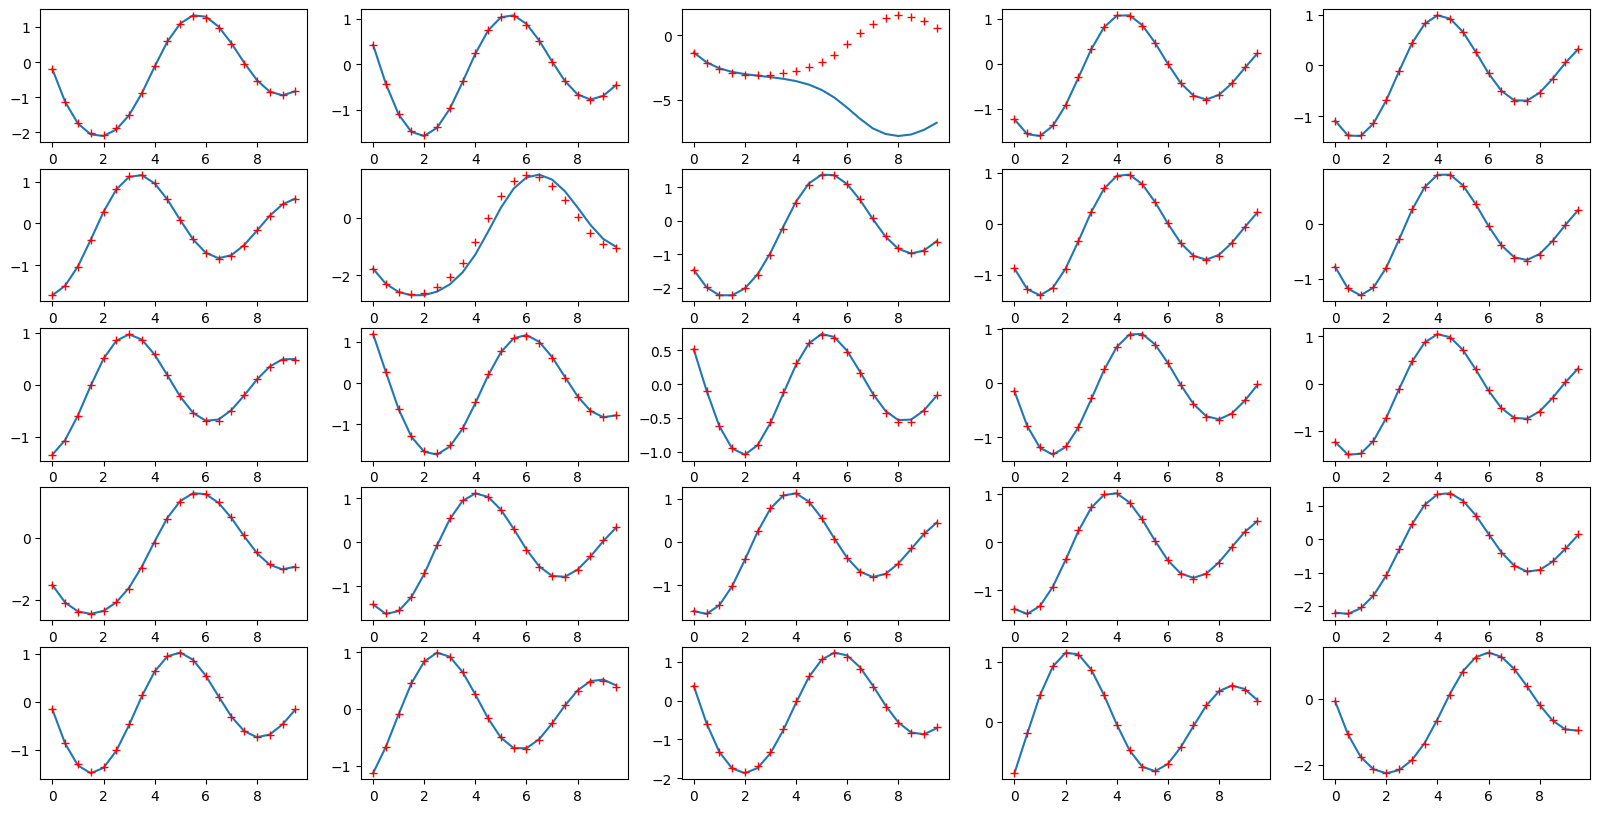

In [29]:
# The code below plots the predicted values

## # pred contains
## pred = ...

plt.figure()
plt.rcParams["figure.figsize"] = [20, 10]
fig, axs = plt.subplots(5, 5)
p = (pred.detach()).numpy()
ptest = pred_test.detach().numpy()

for i in range(5):
    for j in range(5):
        # print(batch["t"][i * 5 + j].shape)
        # print(p[i * 5 + j, 0, :].shape)
        axs[i, j].plot(
            batch["t"][i * 5 + j],
            batch["states"][i * 5 + j, :, 0],
            batch["t"][i * 5 + j],
            p[i * 5 + j, 0, :],
            "r+",
        )


fig, axs = plt.subplots(5, 5)
for batch_test in test_loader:
  for i in range(5):
    for j in range(5):
        axs[i, j].plot(
            batch_test["t"][i * 5 + j],
            batch_test["states"][i * 5 + j, :, 0],
            batch_test["t"][i * 5 + j],
            ptest[i * 5 + j, 0, :],
            "r+",
        )


# Bonus: see [this paper](https://proceedings.neurips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf) [1]
Experiment Neural ODE for other applications:
- **Replacing residual networks with ODEs for supervised learning** (see section 3 in paper), using the adjoint method.
- **Application for irregularly-sampled time series** (see section 5 in the paper).


[1] **Neural Ordinary Differential Equations.**
Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, David K. Duvenaud.
NeurIPS 2018.

## Replacing residual networks with ODEs for supervised learning

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, n_hidden):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(n_hidden, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.fc1(x))
        out = self.fc2(out)
        out += residual  # Adding input to the output (residual connection)
        out = self.relu(out)  # Typically ReLU is applied after adding the residual
        return out


In [16]:
class DerivativeEstimatorRes(nn.Module):
    def __init__(self, n_state: int, n_hidden: int, num_blocks: int):
        super().__init__()
        self.input_layer = nn.Linear(n_state, n_hidden)
        self.blocks = nn.Sequential(
            *[ResidualBlock(n_hidden) for _ in range(num_blocks)]
        )
        self.output_layer = nn.Linear(n_hidden, n_state)
        self.relu = nn.ReLU()

    def forward(self, t, state):
        x = self.relu(self.input_layer(state))
        x = self.blocks(x)
        x = self.output_layer(x)
        return x


In [17]:
class ForecasterRes(nn.Module):
    def __init__(self, n_state, n_hidden,num_blocks, method="rk4"):
        super().__init__()
        self.derivative_estimator = DerivativeEstimatorRes(n_state, n_hidden,num_blocks)
        self.method = method #积分方法



    def forward(self, y0: torch.Tensor, t: torch.LongTensor):
        """Computes the $y_t$ prediction at times $t$
        given the initial state y0 of size (B x N_c).

        Returns a tensor of shape (B x N_c x T)
        """
        # À compléter...
        # 使用 odeint 进行数值积分
        prediction = odeint(self.derivative_estimator, y0, t[0,:], method=self.method)
        prediction=prediction.permute(1,2,0)
        return prediction

In [23]:
n_state = 2
n_hidden = 200
n_epochs = 1001
num_blocks = 3
# tau_1 = 1e-3

forecasterres_net = ForecasterRes(n_state, n_hidden,num_blocks)
optimizer = optim.Adam(forecasterres_net.parameters())  # , lr=tau_1, betas=(0.9, 0.999))
traj_loss = nn.MSELoss()

for e in range(n_epochs):
    # À compléter...
    for batch in train_loader:
        y0 = batch["states"][:, 0, :]

        t = batch["t"]
        # print(t.shape)
        y_true=batch["states"].permute(0,2,1)
        # print(y_true.shape)

        forecasterres_net.train()
        optimizer.zero_grad()
        y_pred=forecasterres_net(y0,t)
        # print(y_pred.shape)
        loss_res=traj_loss(y_pred,y_true)
        loss_res.backward()
        optimizer.step()
    if e % 100 == 0:
        print(f'Epoch {e}: Loss = {loss_res.item()}')



Epoch 0: Loss = 2.971010208129883
Epoch 100: Loss = 0.58299320936203
Epoch 200: Loss = 0.022473150864243507
Epoch 300: Loss = 0.01237920206040144
Epoch 400: Loss = 0.0023349400144070387
Epoch 500: Loss = 0.0008879054803401232
Epoch 600: Loss = 0.003323353361338377
Epoch 700: Loss = 0.09545942395925522
Epoch 800: Loss = 0.0011956858215853572
Epoch 900: Loss = 0.0002858527295757085
Epoch 1000: Loss = 0.00019820431771222502


In [30]:

# Ensure the model is in evaluation mode
forecasterres_net.eval()

# Generating predictions for the training dataset
with torch.no_grad():
    pred_res = []
    for batch in train_loader:
        y0 = batch['states'][:, 0, :]  # Assuming the initial state is at the first time point
        t = batch['t']  # Assuming 't' is properly broadcastable or adjusted as per earlier discussion
        predictions_res = forecasterres_net(y0, t)  # Get predictions from the model
        pred_res.append(predictions_res)

    pred_res = torch.cat(pred_res, dim=0)  # Concatenate list of tensors into a single tensor

# Generating predictions for the testing dataset
with torch.no_grad():
    pred_res_test = []
    for batch_test in test_loader:
        y0 = batch_test['states'][:, 0, :]
        t = batch_test['t']
        predictions_res = forecasterres_net(y0, t)
        pred_res_test.append(predictions_res)

    pred_res_test = torch.cat(pred_res_test, dim=0)  # Concatenate list of tensors into a single tensor


<Figure size 2000x1000 with 0 Axes>

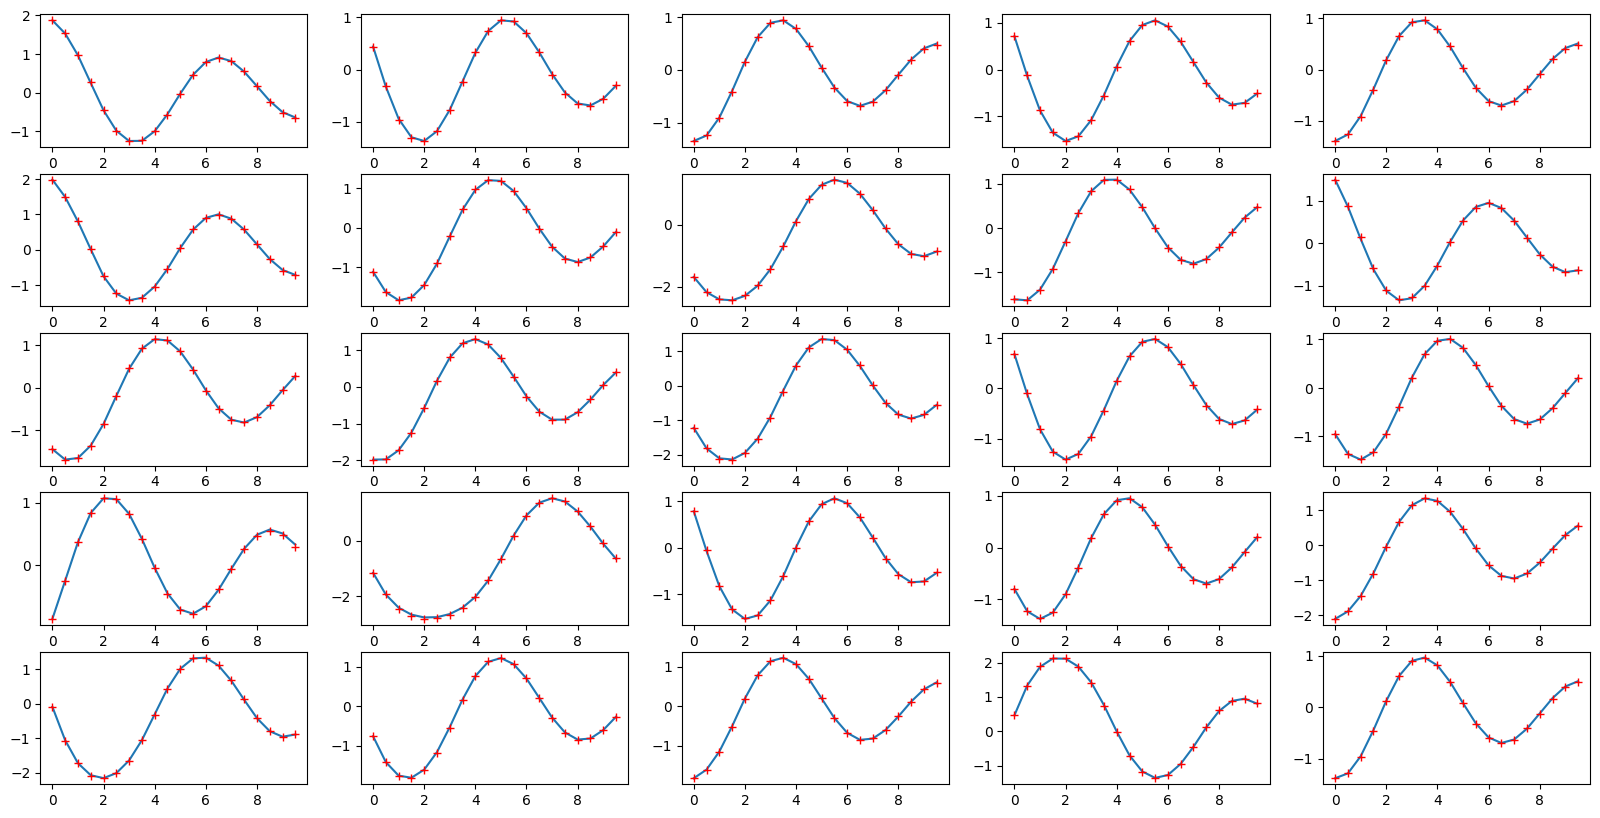

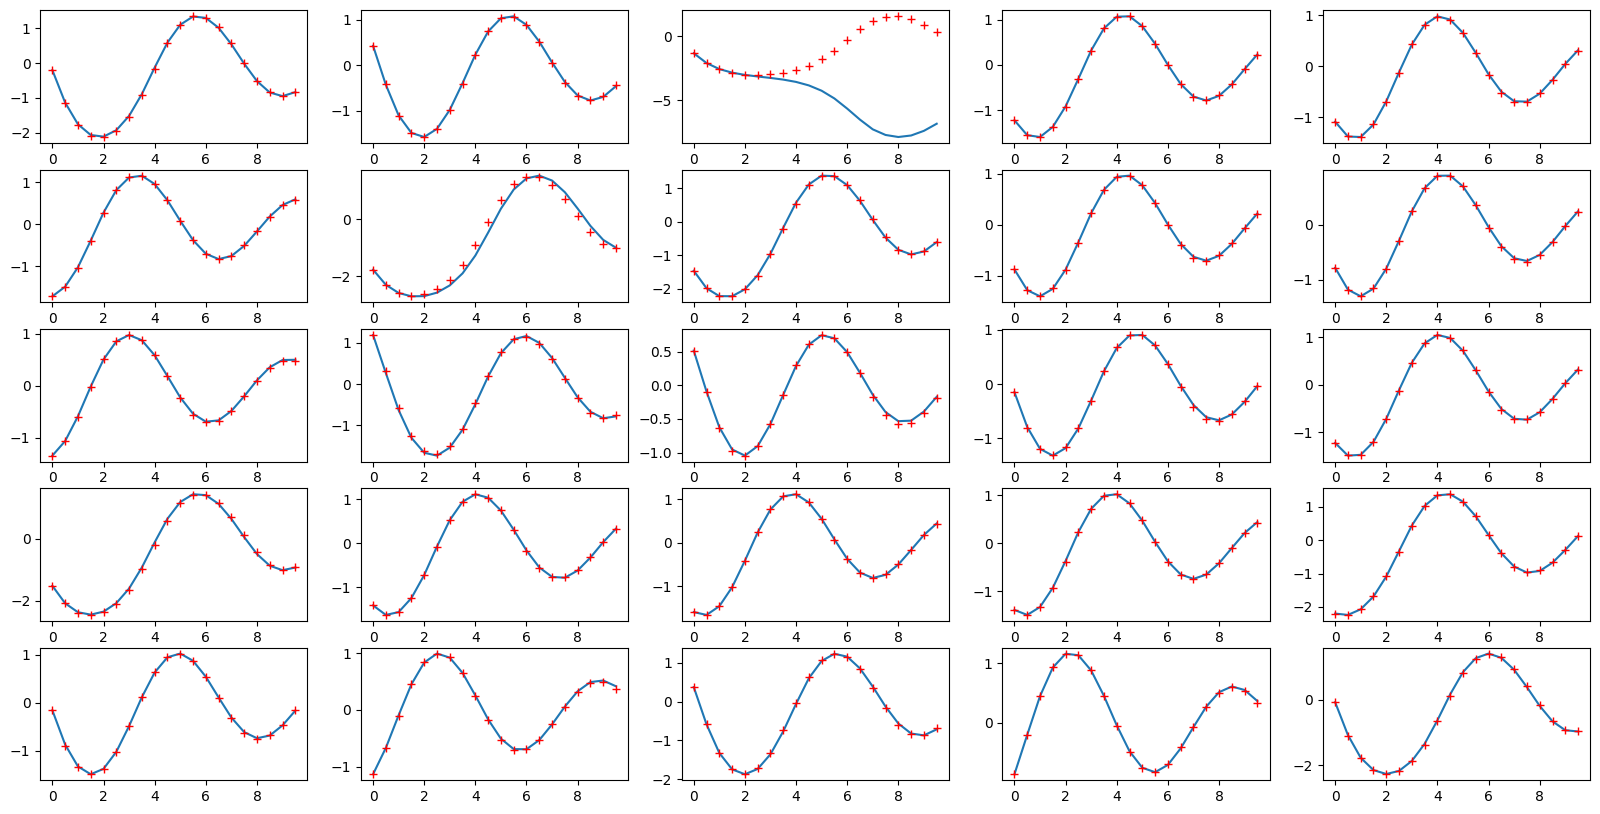

In [31]:
# The code below plots the predicted values

## # pred contains
## pred = ...

plt.figure()
plt.rcParams["figure.figsize"] = [20, 10]
fig, axs = plt.subplots(5, 5)
p_res = (pred_res.detach()).numpy()
ptest_res = pred_res_test.detach().numpy()

for i in range(5):
  for j in range(5):
        # print(batch["t"][i * 5 + j].shape)
        # print(p[i * 5 + j, 0, :].shape)
        axs[i, j].plot(
            batch["t"][i * 5 + j],
            batch["states"][i * 5 + j, :, 0],
            batch["t"][i * 5 + j],
            p_res[i * 5 + j, 0, :],
            "r+",
        )

fig, axs = plt.subplots(5, 5)
for batch_test in test_loader:
  for i in range(5):
    for j in range(5):
        axs[i, j].plot(
            batch_test["t"][i * 5 + j],
            batch_test["states"][i * 5 + j, :, 0],
            batch_test["t"][i * 5 + j],
            ptest_res[i * 5 + j, 0, :],
            "r+",
        )

## Application for irregularly-sampled time series

In [32]:
class DampledPendulumIrregular(Dataset):
    def __init__(self, num_seq: int, time_horizon: int, num_points: list):
        """Creates a new dataset of trajectories

        :param num_seq: Size of the dataset
        :param time_horizon: _description_
        :param num_points: List of integers, each defining number of time points to sample for a trajectory
        """
        super().__init__()

        # À compléter...

        self.omega0_square= (math.pi/3)**2 # FILL WITH YOUR CODE
        self.alpha = 0.2 # FILL WITH YOUR CODE
        self.len = num_seq # NUMBER OF SEQUENCES IN DATASET - FILL WITH YOUR CODE
        self.time_horizon = 10 # FILL WITH YOUR CODE
        self.num_points=num_points

        # This caches the trajectories so we compute them once only
        self.data = [self._generate_trajectory(np.random.choice(num_points))for _ in range(num_seq)]

    def _generate_trajectory(self,num_points):
      self.t_eval=np.sort(np.random.uniform(0,))

    def __getitem__(self, index: int):
        if self.data[index] is None:
            self.data[index] = torch.tensor(self._compute_trajectory(), dtype=torch.float32)
        return {"states": self.data[index], "t": self.t_eval}

    def __len__(self):
        return len(self.data)

    def _get_initial_condition(self):
        """Returns the vector of initial conditions"""
        y0 = np.random.randn(2) * 2.0 - 1
        r = np.random.rand() + 1.3
        y0 = y0 / np.sqrt((y0**2).sum()) * r

        return y0

    def _get__state_derivative(self, t, x):  # coords = [q,p]
        # À compléter...
        theta,omega=x
        dtheta_dt=omega
        domega_dt=-self.omega0_square*np.sin(theta)-self.alpha*omega
        return [dtheta_dt,domega_dt]





<!--bibtex

@inproceedings{nODE-NEURIPS2018,
 author = {Chen, Ricky T. Q. and Rubanova, Yulia and Bettencourt, Jesse and Duvenaud, David K},
 booktitle = {Advances in Neural Information Processing Systems},
 editor = {S. Bengio and H. Wallach and H. Larochelle and K. Grauman and N. Cesa-Bianchi and R. Garnett},
 pages = {},
 publisher = {Curran Associates, Inc.},
 title = {Neural Ordinary Differential Equations},
 url = {https://proceedings.neurips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf},
 volume = {31},
 year = {2018}
}

... Other Bibtex entries go here.

-->

<!--bibtex

@inproceedings{nODE-NEURIPS2018,
 author = {Chen, Ricky T. Q. and Rubanova, Yulia and Bettencourt, Jesse and Duvenaud, David K},
 booktitle = {Advances in Neural Information Processing Systems},
 editor = {S. Bengio and H. Wallach and H. Larochelle and K. Grauman and N. Cesa-Bianchi and R. Garnett},
 pages = {},
 publisher = {Curran Associates, Inc.},
 title = {Neural Ordinary Differential Equations},
 url = {https://proceedings.neurips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf},
 volume = {31},
 year = {2018}
}

... Other Bibtex entries go here.

-->